In [1]:
import numpy as np
from sklearn.utils import resample


# configure bootstrap
n_iterations = 500

def bootstrap(a, b, calculate_statistic):
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        # prepare sample
        sample_a, sample_b = resample(a, b)
        stat = calculate_statistic(sample_a, sample_b)
        stats.append(stat)

    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
    
    return [lower, upper]

In [2]:
# load SVM results
import os
import glob
import pickle
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

svm_results_dir = 'X:\\scratch\\ADNI\\Results'
svm_results_files = [ file for file in glob.glob(os.path.join(svm_results_dir,'ADNI-Parelsnoer*','results.pickle'))]
svm_results_files.sort()
temp_results_files = [file.replace('results.pickle','temp_results.pickle') for file in svm_results_files]

print(svm_results_files)
print(temp_results_files)

features = {'/scratch/ebron/ADNI/adni_ad_baseline_masked.csv': 'Modulated GM maps',
            '/scratch/ebron/ADNI/adni_ad_t1_baseline_masked.csv': 'T1-weighted images',        
            }

svm_auc_means, svm_acc_means, svm_features, svm_class = [], [], [],[]
for svm_results_file in svm_results_files:
    print(svm_results_file)
    p = pickle.load(open(svm_results_file,'rb'))
    print(p.keys())
    
# McNemar for AAIC abstract    
#     TempFolder = os.path.join(svm_results_dir, 'temp_' + str(p['Date'].split('.')[0].replace(' ', '_').replace(':', '_').replace('-', '_')))              
        
# #     TempFolder = os.path.join(svm_results_dir, 'temp_2020_01_27_10_40_33')
#     if os.path.exists(TempFolder):
#         svm_y_pred = np.load(os.path.join(TempFolder, 'y_pred.npy'))
#         svm_y_true = np.load(os.path.join(TempFolder, 'y_true.npy'))
#     else: 
#         continue    
    
    svm_auc_means.append(p['auc_mean'])
    svm_acc_means.append(p['acc_mean'])
    svm_features.append(features[p['DataIn'][0]])
    svm_class.append(p['TestClass'][1])
    svm_label = f"SVM" #with {p['N_splits']} iterations
 
#
# Load temp_results containing individual predictions
svm_y_trues, svm_y_scores, svm_y_preds, svm_auc_cis, svm_acc_cis = [], [], [], [], []
for temp_results_file in temp_results_files:
    print(temp_results_file)
    p = pickle.load(open(temp_results_file,'rb'))
    
    y_test = np.array(p[-3])
    y_score = np.array(p[-2])
    y_pred = np.array(p[-1])
    
    svm_y_trues.append(y_test)
    svm_y_scores.append(y_score)
    svm_y_preds.append(y_pred) 
    
    ci_auc = bootstrap(y_test, y_score[:,1], roc_auc_score) 
    ci_acc = bootstrap(y_test, y_pred, accuracy_score)  
    
    svm_auc_cis.append(ci_auc)
    svm_acc_cis.append(ci_acc)

d = {'svm_auc_means': svm_auc_means, 'svm_auc_cis': svm_auc_cis, 'svm_acc_means': svm_acc_means, 'svm_acc_cis': svm_acc_cis, 'svm_features': svm_features, 'svm_class': svm_class, 'svm_y_trues': svm_y_trues, 'svm_y_scores': svm_y_scores, 'svm_y_preds': svm_y_preds}
df_svm = pd.DataFrame(data=d)
df_svm = df_svm.sort_values(['svm_class', 'svm_features'], ascending=[True,False], ignore_index=True)
print(df_svm)


['X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-ad-2020-04-02-12-03-42\\results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-ad-2020-04-02-12-15-39\\results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-mci-2020-04-02-12-02-43\\results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-mci-2020-04-02-12-14-47\\results.pickle']
['X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-ad-2020-04-02-12-03-42\\temp_results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-ad-2020-04-02-12-15-39\\temp_results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-mci-2020-04-02-12-02-43\\temp_results.pickle', 'X:\\scratch\\ADNI\\Results\\ADNI-Parelsnoer-Vox-mci-2020-04-02-12-14-47\\temp_results.pickle']
X:\scratch\ADNI\Results\ADNI-Parelsnoer-Vox-ad-2020-04-02-12-03-42\results.pickle
dict_keys(['DataIn', 'DataTest', 'Labels', 'Factors', 'Biomarkers_exclude', 'ResultsFile', 'SaveResults', 'TempDirectory', 'InputTempFile', 'Type', 'TestClass', 'Iterations

In [3]:
# load CNN results

import numpy as np
import os
import pandas as pd

import glob
import pickle
import datetime
from sklearn.metrics import roc_auc_score, accuracy_score

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

cnn_auc_means, cnn_acc_means, cnn_features = [], [], []
cnn_y_trues, cnn_y_scores, cnn_y_preds, cnn_auc_cis, cnn_acc_cis = [], [], [], [], []
features_cnn = {'GM': 'Mod GM maps', 'T1': 'T1w images'
            }

experiments=['16257_T1_WB_AD_allCNN_notrain', '16258_GM_WB_AD_allCNN_notrain', '16255_T1_WB_MCI_allCNN_notrain', '16256_GM_WB_MCI_allCNN_notrain']

cnn_class = ['AD', 'AD', 'MCI', 'MCI']

for exp in experiments:
    test_ids = np.load(os.path.join('W:', 'results', exp, 'train_test.npy')).item()['test'][0]
    
    test_results = np.load(os.path.join('W:', 'results', exp, 'results.npy')).item()['test']
    cnn_auc_means.append(test_results['auc'][0])
    cnn_acc_means.append(test_results['acc'][0])
    cnn_features_temp = exp.split('_')[1]
    cnn_features.append(features_cnn[cnn_features_temp])
    
    cnn_y_pred = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_pred.npy'))
    cnn_y_true = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_true.npy'))
    cnn_y_score = np.load(os.path.join('W:','results', exp, 'k0', 'test_y_score.npy'))

    # Sort on subject ids
    cnn_y_pred_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_pred))]
    cnn_y_true_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_true))]
    cnn_y_score_sorted = [cnn_zip for _,cnn_zip in sorted(zip(test_ids, cnn_y_score))]

    cnn_y_trues.append(cnn_y_true_sorted )
    cnn_y_scores.append(cnn_y_score_sorted)
    cnn_y_preds.append(cnn_y_pred_sorted) 
    
    #Bootstrap    
    cnn_y_score_sorted = [i[1] for i in cnn_y_score_sorted]
    cnn_ci_auc = bootstrap(cnn_y_true_sorted, cnn_y_score_sorted, roc_auc_score)
    cnn_ci_acc = bootstrap(cnn_y_true_sorted, cnn_y_pred_sorted, accuracy_score)  
    
    cnn_auc_cis.append(cnn_ci_auc)
    cnn_acc_cis.append(cnn_ci_acc)
    
    
cnn_label = f"CNN" #with {len(results['auc'])} iterations

d = {'cnn_auc_means': cnn_auc_means, 'cnn_auc_cis': cnn_auc_cis, 'cnn_acc_means': cnn_acc_means, 'cnn_acc_cis': cnn_acc_cis, 'cnn_features': cnn_features, 'cnn_class': cnn_class, 'cnn_y_trues': cnn_y_trues, 'cnn_y_scores': cnn_y_scores, 'cnn_y_preds': cnn_y_preds}
df_cnn = pd.DataFrame(data=d)
print(df_cnn)

# restore np.load for future normal usage
np.load = np_load_old

95.0 confidence interval 79.8% and 88.8%
95.0 confidence interval 67.5% and 77.4%
95.0 confidence interval 83.6% and 91.7%
95.0 confidence interval 74.8% and 83.1%
95.0 confidence interval 58.5% and 76.7%
95.0 confidence interval 61.2% and 75.5%
95.0 confidence interval 60.7% and 78.9%
95.0 confidence interval 56.5% and 72.3%
   cnn_auc_means                               cnn_auc_cis  cnn_acc_means  \
0       0.846406  [0.7978976040050405, 0.8883688420543894]       0.727003   
1       0.876083  [0.8358666142449946, 0.9170285537751693]       0.792285   
2       0.679487  [0.5851789763645808, 0.7673223618340544]       0.683453   
3       0.701694   [0.6070171300738065, 0.789236507159558]       0.647482   

                                cnn_acc_cis cnn_features cnn_class  \
0               [0.675, 0.7744807121661721]   T1w images        AD   
1  [0.7477744807121661, 0.8308605341246291]  Mod GM maps        AD   
2  [0.6115107913669064, 0.7553956834532374]   T1w images       MCI   
3  [0.

In [7]:
# Calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

#print(cnn_y_true_sorted)
#print(svm_y_true)

def mcnemar_test(A_pred, A_true, B_pred, B_true):
    
    A_corr = np.array([1 if i==j else 0 for i,j in zip(A_pred, A_true)])
    B_corr = np.array([1 if i==j else 0 for i,j in zip(B_pred, B_true)])

    a = np.sum(np.sum([A_corr, B_corr],axis=0)==2)
    b = np.sum([1 if i==1 and j==0 else 0 for i,j in zip(A_corr, B_corr)])
    c = np.sum([1 if i==0 and j==1 else 0 for i,j in zip(A_corr, B_corr)])
    d = np.sum(np.sum([A_corr, B_corr],axis=0)==0)


    # define contingency table
    table = [[a, b], [c, d]]
    print(table)
    mcnemar_result = mcnemar(table, exact=False, correction=True)
    print(mcnemar_result)
          
    return mcnemar_result.pvalue

pvalues_class = pd.Series(0.1)
pvalues_feat_cnn = pd.Series(0.1)
pvalues_feat_svm = pd.Series(0.1)
for j in range(0,2):    

    svm_class_j = df_svm['svm_class'].unique()[j]
    
    cnn_class_j = df_cnn['cnn_class'].unique()[j]
    
    df_svm_selected = df_svm[df_svm['svm_class']==svm_class_j]
    df_cnn_selected = df_cnn[df_cnn['cnn_class']==cnn_class_j]
    
    # test cnn vs svm
    for i, features in enumerate(df_cnn_selected['cnn_features']):
        idx=df_cnn_selected.index.tolist()[i]
        print(f"Class {svm_class_j} and {cnn_class_j}, index: {idx}, compare classifiers for {features}")
        pvalues_class[idx] = mcnemar_test(df_cnn_selected['cnn_y_preds'].tolist()[i], df_cnn_selected['cnn_y_trues'].tolist()[i], df_svm_selected['svm_y_preds'].tolist()[i], df_svm_selected['svm_y_trues'].tolist()[i])    
        print(pvalues_class)
        
        # test features
        print(f"Class {svm_class_j} and {cnn_class_j}, index: {idx}, compare features for CNN")
        pvalues_feat_cnn[idx] = mcnemar_test(df_cnn_selected['cnn_y_preds'].tolist()[0], df_cnn_selected['cnn_y_trues'].tolist()[0], df_cnn_selected['cnn_y_preds'].tolist()[1], df_cnn_selected['cnn_y_trues'].tolist()[1])    
        print(f"Class {svm_class_j} and {cnn_class_j}, index: {idx}, compare features for SVM")
        pvalues_feat_svm[idx] = mcnemar_test(df_svm_selected['svm_y_preds'].tolist()[0], df_svm_selected['svm_y_trues'].tolist()[0], df_svm_selected['svm_y_preds'].tolist()[1], df_svm_selected['svm_y_trues'].tolist()[1])    

df_svm['mcnemar_class'] = pvalues_class
df_cnn['mcnemar_class'] = pvalues_class

df_cnn['mcnemar_feat'] = pvalues_feat_cnn
df_svm['mcnemar_feat'] = pvalues_feat_svm

print(df_svm)

Class AD_PSI and AD, index: 0, compare classifiers for T1w images
[[158, 87], [68, 24]]
pvalue      0.1482347672901318
statistic   2.0903225806451613
0    0.148235
dtype: float64
Class AD_PSI and AD, index: 0, compare features for CNN
[[221, 24], [46, 46]]
pvalue      0.0120737972431229
statistic   6.3
Class AD_PSI and AD, index: 0, compare features for SVM
[[201, 25], [56, 55]]
pvalue      0.0008581206663936758
statistic   11.11111111111111
Class AD_PSI and AD, index: 1, compare classifiers for Mod GM maps
[[206, 61], [51, 19]]
pvalue      0.3950915849041501
statistic   0.7232142857142857
0    0.148235
1    0.395092
dtype: float64
Class AD_PSI and AD, index: 1, compare features for CNN
[[221, 24], [46, 46]]
pvalue      0.0120737972431229
statistic   6.3
Class AD_PSI and AD, index: 1, compare features for SVM
[[201, 25], [56, 55]]
pvalue      0.0008581206663936758
statistic   11.11111111111111
Class MCIc and MCI, index: 2, compare classifiers for T1w images
[[59, 36], [30, 14]]
pvalue 

In [124]:
df_svm

,svm_auc_means,svm_auc_cis,svm_acc_means,svm_acc_cis,svm_features,svm_class,svm_y_trues,svm_y_scores,svm_y_preds,mcnemar_class,mcnemar_feat
0,0.749854,"[0.6959101701626926, 0.797933415146292]",0.670623,"[0.6231454005934718, 0.7181008902077152]",T1-weighted images,AD_PSI,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[[0.47916238265153044, 0.5208376173484693], [0...","[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.148235,0.000858
1,0.896220,"[0.855346594133078, 0.9317722258308541]",0.762611,"[0.7149851632047479, 0.8041543026706232]",Modulated GM maps,AD_PSI,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[[0.3468545072132955, 0.6531454927867045], [0....","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.395092,0.000858
2,0.566392,"[0.46773809523809523, 0.6699770104190652]",0.640288,"[0.5539568345323741, 0.7232014388489207]",T1-weighted images,MCIc,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[[0.765936775423151, 0.23406322457684886], [0....","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.538253,0.719438
3,0.664606,"[0.5762330954744574, 0.7597487530200295]",0.618705,"[0.5323741007194245, 0.697841726618705]",Modulated GM maps,MCIc,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0658666024016724, 0.9341333975983275], [0....","[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0.719918,0.719438


In [125]:
df_cnn

,cnn_auc_means,cnn_auc_cis,cnn_acc_means,cnn_acc_cis,cnn_features,cnn_class,cnn_y_trues,cnn_y_scores,cnn_y_preds,mcnemar_class,mcnemar_feat
0,0.846406,"[0.8464059427572646, 0.8464059427572646]",0.727003,"[0.6765578635014837, 0.7701038575667656]",T1w images,AD,"[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...","[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, ...",0.148235,0.012074
1,0.876083,"[0.8760833151263563, 0.8760833151263563]",0.792285,"[0.7521513353115727, 0.8324183976261127]",Mod GM maps,AD,"[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, ...",0.395092,0.012074
2,0.679487,"[0.6794871794871794, 0.6794871794871794]",0.683453,"[0.60431654676259, 0.7553956834532374]",T1w images,MCI,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.538253,0.486234
3,0.701694,"[0.7016941391941393, 0.7016941391941393]",0.647482,"[0.5683453237410072, 0.7266187050359713]",Mod GM maps,MCI,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.719918,0.486234


In [4]:
# Function for plot labels
def autolabel(rects, xpos='center',decimals=2, height_offset=0):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        float_format = '{:.' + str(decimals) + 'f}'
        ax.annotate(float_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height+height_offset),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

0.1482347672901318
0.3950915849041501
0.0008581206663936758
0.0120737972431229
0.5382526579885007
0.7199178531944465
0.7194375444233914
0.48623432138829725


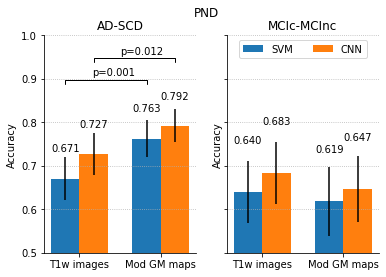

In [8]:
# Make plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from itertools import repeat

what='acc'

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.suptitle('PND')

for i,ax in enumerate([ax1, ax2]):    
    
    svm_class_j = df_svm['svm_class'].unique()[i]
    cnn_class_j = df_cnn['cnn_class'].unique()[i]
    
    df_svm_selected = df_svm[df_svm['svm_class']==svm_class_j]
    df_cnn_selected = df_cnn[df_cnn['cnn_class']==cnn_class_j]

    ind = np.arange(len(df_svm_selected['svm_auc_means']))  # the x locations for the groups
    width = 0.35  # the width of the bars    
        
    if what=='AUC':
        rects1 = ax.bar(ind - width/2, df_svm_selected['svm_auc_means'].tolist(), width, 
                        yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_svm_selected['svm_auc_cis'], df_svm_selected['svm_auc_means'])], 
                        label=svm_label)
        rects2 = ax.bar(ind + width/2, df_cnn_selected['cnn_auc_means'].tolist(), width, 
                        yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_cnn_selected['cnn_auc_cis'], df_cnn_selected['cnn_auc_means'])],
                        label=cnn_label)
    else:
        rects1 = ax.bar(ind - width/2, df_svm_selected['svm_acc_means'].tolist(), width, 
                        yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_svm_selected['svm_acc_cis'], df_svm_selected['svm_acc_means'])],
                        label=svm_label)
        rects2 = ax.bar(ind + width/2, df_cnn_selected['cnn_acc_means'].tolist(), width, 
                        yerr=[np.subtract(ci[1], mean) for ci, mean in zip(df_cnn_selected['cnn_acc_cis'], df_cnn_selected['cnn_acc_means'])],
                        label=cnn_label)       

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if what=='AUC':
        ax.set_ylabel('Area-under-the-ROC-curve (AUC)')
    else:
        ax.set_ylabel('Accuracy')
    if i:
        ax.set_title('MCIc-MCInc')
    else:
        ax.set_title('AD-SCD')
    ax.set_xticks(ind)

    ax.set_xticklabels(df_cnn_selected['cnn_features'])
    ax.set_ylim([0.5,1])
    ax.grid(axis='y', linestyle='dotted')
    if i:
        lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i==0:
        autolabel(rects1, "center", 3, .05)
        autolabel(rects2, "center", 3, .05)
    else:
        autolabel(rects1, "center", 3, .1)
        autolabel(rects2, "center", 3, .1)          


    # Custom function to draw the diff bars
    if what!='AUC':
        props = {'connectionstyle':'bar','arrowstyle':'-',\
                     'shrinkA':20,'shrinkB':20,'linewidth':1}

        # svm vs cnn
        for j in range(0,2):
            pvalue=df_svm_selected['mcnemar_class'].tolist()[j]
            print(pvalue)
            y = np.max([df_svm_selected['svm_acc_means'].tolist()[j], df_cnn_selected['cnn_acc_means'].tolist()[j]])
            if pvalue < 0.05 /4:                 
                ax.annotate(f'p={pvalue:.3f}', xy=(ind[i]-width/3,y+0.06))
                ax.annotate('', xy=(ind[i]-width/2,y), xytext=(ind[i]+width/2,y), arrowprops=props)
        # svm feat
        pvalue=df_svm_selected['mcnemar_feat'].tolist()[0]
        print(pvalue)
        if pvalue < 0.05 /4: 
            y = y + 0.05
            ax.annotate(f'p={pvalue:.3f}', xy=((ind[0] + ind[1]) / 2 - width, y+0.065))
            ax.annotate('', xy=(ind[0]-width/2,y), xytext=(ind[1]-width/2,y), arrowprops=props)   
        # cnn feat
        pvalue=df_cnn_selected['mcnemar_feat'].tolist()[0]
        print(pvalue)
        if pvalue < 0.05 /4: 
            y = y + 0.05
            ax.annotate(f'p={pvalue:.3f}', xy=((ind[0] + ind[1]) / 2, y+0.065))
            ax.annotate('', xy=(ind[0]+width/2,y), xytext=(ind[1]+width/2,y), arrowprops=props)          
        
        
#f.tight_layout()

plt.show()

# Converting datetime object to string
dateTimeObj = datetime.now()
 
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H-%M")

if what=='AUC':
    figure_name = f'Plot3_PSI_CNNSVM_{timestampStr}'
else:
    figure_name = f'Plot3_PSI_CNNSVM_Acc_{timestampStr}'

f.savefig(figure_name, dpi=300, facecolor='w', edgecolor='w', bbox_extra_artists=(lgd,))